#Goal:

Develop a proof-of-concept ML model for identifying bowel sounds in audio data and differentiating between 3 main classes:

Single burst (labelled b)
Multiple burst (labelled mb)
Harmonic (labelled h)
The model should identify the start time, end time and type of each bowel sound.

In [28]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, lfilter
from collections import defaultdict
from tqdm import tqdm

# Seed setup
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


def prepare_dataloaders(audio_file, annotation_file, batch_size=32, segment_duration=0.2, stride_duration=0.05):
    dataset = BowelSoundDataset(audio_file, annotation_file,
                                segment_duration=segment_duration,
                                stride_duration=stride_duration, noise_std=0.005)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    return train_loader, val_loader, val_ds



# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --------------------------
# Utils
# --------------------------
def lowpass_filter(signal, sr, cutoff=2000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, signal)

Using device: cuda


# Bowel Sound Dataset Class with Segmentation and Augmentation

In [29]:
class BowelSoundDataset(Dataset):
    LABEL_MAP = {'b': 0, 'mb': 1, 'h': 2, 'none': 3}

    def __init__(self, audio_file, annotation_file=None, segment_duration=0.2,
                 stride_duration=0.05, augment=False, noise_std=0.005):
        self.audio_file = audio_file
        self.annotation_file = annotation_file
        self.segment_duration = segment_duration
        self.stride_duration = stride_duration
        self.augment = augment
        self.noise_std = noise_std
        self.spectrograms, self.labels, self.start_times, self.end_times = self.prepare_data()

    def prepare_data(self):
        audio, sr = librosa.load(self.audio_file, sr=None)
        audio = lowpass_filter(audio, sr)
        segment_samples = int(sr * self.segment_duration)
        stride_samples = int(sr * self.stride_duration)

        specs, start_times = [], []
        for i in range(0, len(audio) - segment_samples + 1, stride_samples):
            segment = audio[i:i + segment_samples]
            if len(segment) < 512:
                continue

            # Augment with Gaussian noise
            if self.augment:
                noise = np.random.normal(0, self.noise_std, segment.shape)
                segment = segment + noise
                segment = np.clip(segment, -1.0, 1.0)  # prevent clipping artifacts

            spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=512, hop_length=128)
            spec_db = librosa.power_to_db(spec, ref=np.max)
            spec_db = np.pad(spec_db, ((0, 0), (0, max(0, 32 - spec_db.shape[1]))), mode='constant')[:, :32]
            specs.append(torch.tensor(spec_db, dtype=torch.float32))
            start_times.append(i / sr)

        # Initialize labels and interval annotations
        ann_labels, ann_start, ann_end = [], [], []
        if self.annotation_file:
            annotations = pd.read_csv(self.annotation_file, sep='\t', header=None,
                                      names=['Start', 'End', 'Label'])
            annotations = annotations[annotations['Label'].isin(['b', 'mb', 'h'])]
            ann_labels = list(annotations['Label'])
            ann_start = list(annotations['Start'])
            ann_end = list(annotations['End'])

        total_duration = len(audio) / sr
        N = len(specs)
        label_t = torch.full((N,), self.LABEL_MAP['none'], dtype=torch.long)
        start_t = torch.zeros(N, dtype=torch.float32)
        end_t = torch.zeros(N, dtype=torch.float32)

        for i, t in enumerate(start_times):
            for lbl, s, e in zip(ann_labels, ann_start, ann_end):
                if s <= t <= e:
                    label_t[i] = self.LABEL_MAP[lbl]
                    start_t[i] = s / total_duration
                    end_t[i] = e / total_duration
                    break

        return specs, label_t, start_t, end_t

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.spectrograms[idx].unsqueeze(0), self.labels[idx], self.start_times[idx], self.end_times[idx]


# Confirm that the augmentation is working

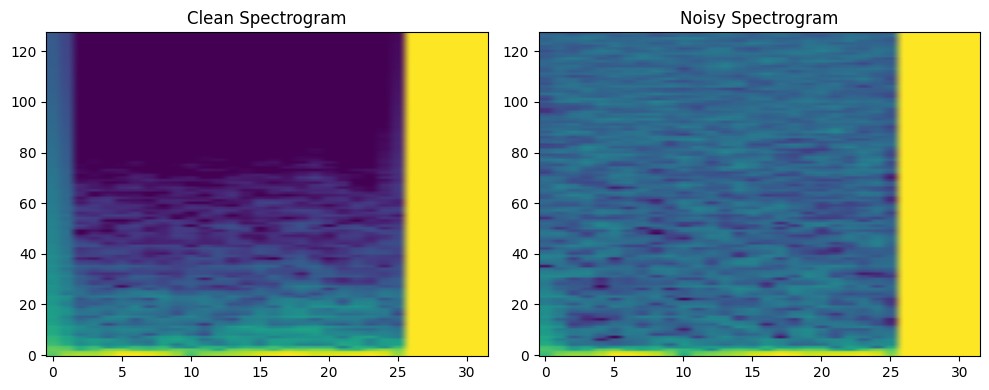

In [27]:
import matplotlib.pyplot as plt

audio_file = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.wav"
annotation_file = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.txt"

ds_no_aug = BowelSoundDataset(audio_file, augment=False)
ds_aug = BowelSoundDataset(audio_file, augment=True, noise_std=0.005)

spec_clean, *_ = ds_no_aug[10]
spec_noisy, *_ = ds_aug[10]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(spec_clean[0], aspect='auto', origin='lower')
plt.title("Clean Spectrogram")

plt.subplot(1, 2, 2)
plt.imshow(spec_noisy[0], aspect='auto', origin='lower')
plt.title("Noisy Spectrogram")
plt.tight_layout()
plt.show()


# ML model architecture

In [30]:
# Stage 1 model (classification)
class Stage1Model(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.AvgPool2d(2)
        self.dropout = nn.Dropout(0.3)

        dummy = torch.zeros(1, 1, 128, 32)
        out = self._forward_conv(dummy)
        flat = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_conv(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

# Stage 2 model (regression for normalized start/end)
class Stage2Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.AvgPool2d(2)
        self.dropout = nn.Dropout(0.2)

        dummy = torch.zeros(1, 1, 128, 32)
        out = self._forward_conv(dummy)
        flat = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat, 128)
        self.fc_scale = nn.Linear(128, 1)
        self.fc_offset = nn.Linear(128, 1)

    def _forward_conv(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        # Apply sigmoid to keep outputs in [0,1]
        scale = torch.sigmoid(self.fc_scale(x))
        offset = torch.sigmoid(self.fc_offset(x))
        return scale, offset




# Custom Loss Function for Interval Regression using IoU and Penalties

In [ ]:
# Custom IoU‐based loss with clamping to avoid NaNs
def modified_iou_loss(pred_start, pred_end, true_start, true_end):
    pred_s = torch.min(pred_start, pred_end).clamp(0,1)
    pred_e = torch.max(pred_start, pred_end).clamp(0,1)
    true_s = torch.min(true_start, true_end).clamp(0,1)
    true_e = torch.max(true_start, true_end).clamp(0,1)

    inter_s = torch.max(pred_s, true_s)
    inter_e = torch.min(pred_e, true_e)
    intersection = torch.clamp(inter_e - inter_s, min=0)
    union = (pred_e - pred_s) + (true_e - true_s) - intersection + 1e-6
    iou_loss = 1 - (intersection / union)

    mid_p = (pred_s + pred_e) / 2
    mid_t = (true_s + true_e) / 2
    length_t = true_e - true_s + 1e-6
    dist_penalty = torch.abs(mid_p - mid_t) / length_t

    len_p = pred_e - pred_s + 1e-6
    len_t = length_t
    scale_penalty = torch.abs(torch.log(len_p / len_t))

    return iou_loss + dist_penalty + scale_penalty

# Stage 1: Model Training, Validation, and Metrics Visualization

In [31]:
# Training and evaluation logic with predicted vs true interval plots
def train_and_evaluate_classification(audio_file, annotation_file, num_epochs=10, batch_size=16):

    train_loader, val_loader, val_ds = prepare_dataloaders(audio_file, annotation_file, batch_size=batch_size)

    stage1 = Stage1Model(num_classes=4).to(device)


    weights = torch.tensor([1/857, 1/773, 1/80, 1/3000], device=device)
    weights = weights / weights.sum()
    criterion1 = nn.CrossEntropyLoss(weight=weights)


    optimizer1 = optim.Adam(stage1.parameters(), lr=0.001, weight_decay=1e-4)


    history = {
        'train_loss1': [], 'val_loss1': [], 'train_acc': [], 'val_acc': [],
        'train_loss2': [], 'val_loss2': []
    }

    all_preds, all_labels = [], []

    pred_vs_true_intervals = {'pred_start': [], 'pred_end': [], 'true_start': [], 'true_end': []}

    for epoch in range(num_epochs):
        # --- Stage 1 ---
        stage1.train()
        t_loss1, correct, total = 0.0, 0, 0

        for X, y, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1} Stage 1"):
            X, y = X.to(device), y.to(device)
            optimizer1.zero_grad()
            logits = stage1(X)
            loss = criterion1(logits, y)
            loss.backward()
            optimizer1.step()

            t_loss1 += loss.item()
            pred = torch.argmax(logits, dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        history['train_loss1'].append(t_loss1 / len(train_loader))
        history['train_acc'].append(train_acc)

        # Validation for Stage 1
        stage1.eval()
        v_loss1, v_correct = 0.0, 0
        with torch.no_grad():
            for X, y, _, _ in val_loader:
                X, y = X.to(device), y.to(device)
                logits = stage1(X)
                loss = criterion1(logits, y)
                v_loss1 += loss.item()
                pred = torch.argmax(logits, dim=1)
                v_correct += (pred == y).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        history['val_loss1'].append(v_loss1 / len(val_loader))
        history['val_acc'].append(v_correct / len(val_ds))


        print(f"[Epoch {epoch+1}] Stage 1 – Train Loss: {history['train_loss1'][-1]:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {history['val_loss1'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")


    # Save models
    torch.save(stage1.state_dict(), "/content/drive/MyDrive/Colab Notebooks/stage1_model2.pth")


    # Plots for Stage 1
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss1'], label='Train Loss (Stage 1)')
    plt.plot(history['val_loss1'], label='Val Loss (Stage 1)')
    plt.title("Stage 1 Loss"); plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc'); plt.plot(history['val_acc'], label='Val Acc')
    plt.title("Stage 1 Accuracy"); plt.legend()
    plt.tight_layout()
    plt.show()


    # Confusion matrix and classification report including 'none'
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['b', 'mb', 'h', 'none'])
    disp.plot()
    plt.title("Stage 1 Confusion Matrix")
    plt.show()

    print("Classification Report (Stage 1):")
    print(classification_report(all_labels, all_preds, target_names=['b', 'mb', 'h', 'none']))

# Stage 2: Model Training, Validation, and Metrics Visualization

In [37]:
# Training and evaluation logic with predicted vs true interval plots
def train_and_evaluate_Regression(audio_file, annotation_file, num_epochs=10, batch_size=16):
    train_loader, val_loader, _ = prepare_dataloaders(audio_file, annotation_file, batch_size=batch_size)

    stage2 = Stage2Model().to(device)
    optimizer2 = optim.Adam(stage2.parameters(), lr=0.0001, weight_decay=1e-4)

    history = {
        'train_loss2': [], 'val_loss2': []
    }

    # Only collect final epoch predictions
    pred_vs_true_intervals = {'pred_start': [], 'pred_end': [], 'true_start': [], 'true_end': []}

    for epoch in range(num_epochs):
        # --- Stage 2 training ---
        stage2.train()
        t_loss2 = 0.0

        for X, y, s, e in tqdm(train_loader, desc=f"Epoch {epoch+1} Stage 2"):
            X, y, s, e = X.to(device), y.to(device), s.to(device), e.to(device)
            mask = (y != BowelSoundDataset.LABEL_MAP['none'])
            if mask.sum() == 0:
                continue

            Xp, sp, ep = X[mask], s[mask], e[mask]
            optimizer2.zero_grad()
            scale_p, offset_p = stage2(Xp)
            loss = sum(modified_iou_loss(scale_p[i], offset_p[i], sp[i], ep[i]) for i in range(Xp.size(0)))
            loss = loss / Xp.size(0)
            loss.backward()
            optimizer2.step()

            t_loss2 += loss.item()

        history['train_loss2'].append(t_loss2 / len(train_loader))

        # --- Stage 2 validation ---
        stage2.eval()
        v_loss2 = 0.0
        with torch.no_grad():
            for X, y, s, e in val_loader:
                X, y, s, e = X.to(device), y.to(device), s.to(device), e.to(device)
                mask = (y != BowelSoundDataset.LABEL_MAP['none'])
                if mask.sum() == 0:
                    continue

                Xp, sp, ep = X[mask], s[mask], e[mask]
                scale_p, offset_p = stage2(Xp)
                loss = sum(modified_iou_loss(scale_p[i], offset_p[i], sp[i], ep[i]) for i in range(Xp.size(0)))
                v_loss2 += loss.item()

                #  Collect predictions only in the LAST epoch
                if epoch == num_epochs - 1:
                    pred_vs_true_intervals['pred_start'].extend(scale_p.view(-1).detach().cpu().numpy())
                    pred_vs_true_intervals['pred_end'].extend(offset_p.view(-1).detach().cpu().numpy())
                    pred_vs_true_intervals['true_start'].extend(sp.view(-1).detach().cpu().numpy())
                    pred_vs_true_intervals['true_end'].extend(ep.view(-1).detach().cpu().numpy())


        history['val_loss2'].append(v_loss2 / len(val_loader))

        print(f"[Epoch {epoch+1}] Stage 2 – Train Loss: {history['train_loss2'][-1]:.4f}, Val Loss: {history['val_loss2'][-1]:.4f}")

    #  Plot Predicted vs True Intervals – after training
    plt.figure(figsize=(8, 4))

    plt.scatter(
        pred_vs_true_intervals['true_start'][:50],
        pred_vs_true_intervals['true_end'][:50],
        color='blue', label='True intervals'
    )

    plt.scatter(
        pred_vs_true_intervals['pred_start'][:50],
        pred_vs_true_intervals['pred_end'][:50],
        color='red', marker='x', label='Predicted intervals'
    )

    plt.xlabel('Start Time (normalized)')
    plt.ylabel('End Time (normalized)')
    plt.title(f'Predicted vs True Intervals (Stage 2)')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    # Save model
    torch.save(stage2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/stage2_model.pth")

    # Plot Loss
    plt.figure(figsize=(6, 4))
    plt.plot(history['train_loss2'], label='Train IoU Loss (Stage 2)')
    plt.plot(history['val_loss2'], label='Val IoU Loss (Stage 2)')
    plt.title("Stage 2 IoU Loss"); plt.legend()
    plt.tight_layout()
    plt.show()


# Run: Stage 1 Training and Validation

Epoch 1 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 286.74it/s]


[Epoch 1] Stage 1 – Train Loss: 0.9602, Acc: 0.6732, Val Loss: 0.7032, Val Acc: 0.8086


Epoch 2 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 289.47it/s]


[Epoch 2] Stage 1 – Train Loss: 0.7532, Acc: 0.7644, Val Loss: 0.6503, Val Acc: 0.8100


Epoch 3 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 290.09it/s]


[Epoch 3] Stage 1 – Train Loss: 0.7254, Acc: 0.7706, Val Loss: 0.7489, Val Acc: 0.7736


Epoch 4 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 288.86it/s]


[Epoch 4] Stage 1 – Train Loss: 0.7014, Acc: 0.7770, Val Loss: 0.6450, Val Acc: 0.7714


Epoch 5 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 287.52it/s]


[Epoch 5] Stage 1 – Train Loss: 0.6829, Acc: 0.7842, Val Loss: 0.6296, Val Acc: 0.7896


Epoch 6 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 286.51it/s]


[Epoch 6] Stage 1 – Train Loss: 0.6705, Acc: 0.7835, Val Loss: 0.6258, Val Acc: 0.7794


Epoch 7 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 288.54it/s]


[Epoch 7] Stage 1 – Train Loss: 0.6600, Acc: 0.7898, Val Loss: 0.6872, Val Acc: 0.6717


Epoch 8 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 288.07it/s]


[Epoch 8] Stage 1 – Train Loss: 0.6670, Acc: 0.7846, Val Loss: 0.6168, Val Acc: 0.8129


Epoch 9 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 286.33it/s]


[Epoch 9] Stage 1 – Train Loss: 0.6377, Acc: 0.7953, Val Loss: 0.6174, Val Acc: 0.8185


Epoch 10 Stage 1: 100%|██████████| 1107/1107 [00:03<00:00, 288.02it/s]


[Epoch 10] Stage 1 – Train Loss: 0.6329, Acc: 0.7906, Val Loss: 0.6059, Val Acc: 0.8288


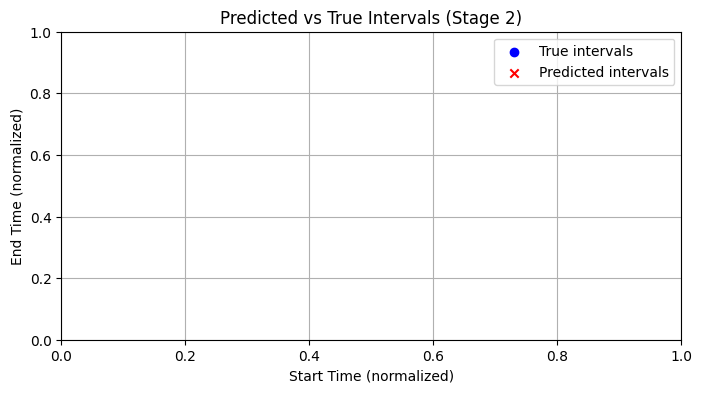

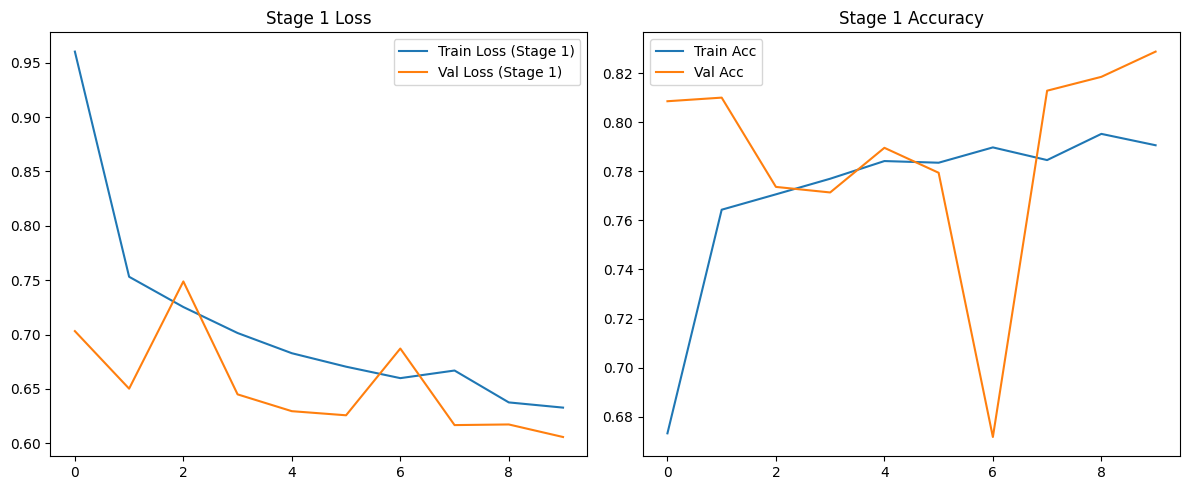

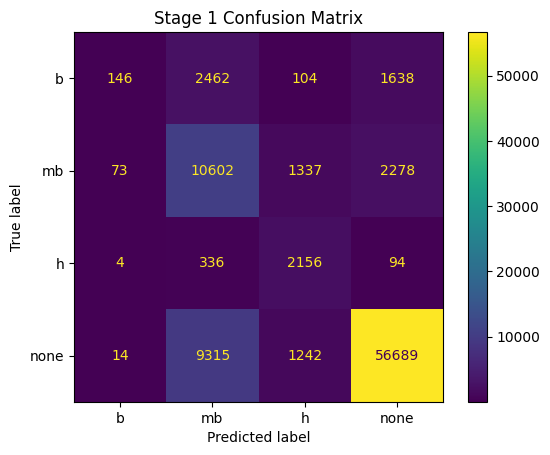

Classification Report (Stage 1):
              precision    recall  f1-score   support

           b       0.62      0.03      0.06      4350
          mb       0.47      0.74      0.57     14290
           h       0.45      0.83      0.58      2590
        none       0.93      0.84      0.89     67260

    accuracy                           0.79     88490
   macro avg       0.62      0.61      0.53     88490
weighted avg       0.83      0.79      0.79     88490



In [33]:

# Run training (replace filenames with your actual data paths)
audio_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.wav"
annotation_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.txt"

train_and_evaluate_classification(audio_path, annotation_path, num_epochs=10, batch_size=32)

# Run: Stage 2 Training and Validation

Epoch 1 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.78it/s]


[Epoch 1] Stage 2 – Train Loss: 1020.2580, Val Loss: 7129.6924


Epoch 2 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.51it/s]


[Epoch 2] Stage 2 – Train Loss: 860.7519, Val Loss: 6550.6672


Epoch 3 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 64.33it/s]


[Epoch 3] Stage 2 – Train Loss: 883.0307, Val Loss: 6680.5314


Epoch 4 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.99it/s]


[Epoch 4] Stage 2 – Train Loss: 835.8809, Val Loss: 6500.4646


Epoch 5 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.79it/s]


[Epoch 5] Stage 2 – Train Loss: 804.5841, Val Loss: 6250.0764


Epoch 6 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 64.01it/s]


[Epoch 6] Stage 2 – Train Loss: 783.6739, Val Loss: 6062.5154


Epoch 7 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 64.07it/s]


[Epoch 7] Stage 2 – Train Loss: 868.6913, Val Loss: 6866.1486


Epoch 8 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 64.12it/s]


[Epoch 8] Stage 2 – Train Loss: 805.7608, Val Loss: 6308.9949


Epoch 9 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 62.88it/s]


[Epoch 9] Stage 2 – Train Loss: 761.3709, Val Loss: 5753.9548


Epoch 10 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.83it/s]


[Epoch 10] Stage 2 – Train Loss: 736.1586, Val Loss: 6226.8490


Epoch 11 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.80it/s]


[Epoch 11] Stage 2 – Train Loss: 737.2790, Val Loss: 5425.2351


Epoch 12 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 64.09it/s]


[Epoch 12] Stage 2 – Train Loss: 703.1376, Val Loss: 5446.1199


Epoch 13 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.62it/s]


[Epoch 13] Stage 2 – Train Loss: 679.3888, Val Loss: 5151.5193


Epoch 14 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.59it/s]


[Epoch 14] Stage 2 – Train Loss: 672.9103, Val Loss: 5457.9170


Epoch 15 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.29it/s]


[Epoch 15] Stage 2 – Train Loss: 652.7564, Val Loss: 5135.3526


Epoch 16 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.49it/s]


[Epoch 16] Stage 2 – Train Loss: 639.0725, Val Loss: 5001.9965


Epoch 17 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.80it/s]


[Epoch 17] Stage 2 – Train Loss: 636.1868, Val Loss: 4860.1751


Epoch 18 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.62it/s]


[Epoch 18] Stage 2 – Train Loss: 629.5598, Val Loss: 4744.3023


Epoch 19 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.82it/s]


[Epoch 19] Stage 2 – Train Loss: 610.5089, Val Loss: 4810.9758


Epoch 20 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.61it/s]


[Epoch 20] Stage 2 – Train Loss: 606.9990, Val Loss: 4683.7583


Epoch 21 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.50it/s]


[Epoch 21] Stage 2 – Train Loss: 595.8592, Val Loss: 4886.8327


Epoch 22 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.33it/s]


[Epoch 22] Stage 2 – Train Loss: 585.5836, Val Loss: 4572.6854


Epoch 23 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.26it/s]


[Epoch 23] Stage 2 – Train Loss: 572.4026, Val Loss: 4559.0102


Epoch 24 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.73it/s]


[Epoch 24] Stage 2 – Train Loss: 579.1656, Val Loss: 4664.0705


Epoch 25 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.70it/s]


[Epoch 25] Stage 2 – Train Loss: 568.2899, Val Loss: 4548.8709


Epoch 26 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.91it/s]


[Epoch 26] Stage 2 – Train Loss: 560.3884, Val Loss: 5044.5277


Epoch 27 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 64.00it/s]


[Epoch 27] Stage 2 – Train Loss: 560.7632, Val Loss: 4683.7032


Epoch 28 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.87it/s]


[Epoch 28] Stage 2 – Train Loss: 549.0828, Val Loss: 4545.1884


Epoch 29 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.89it/s]


[Epoch 29] Stage 2 – Train Loss: 542.0655, Val Loss: 4960.0512


Epoch 30 Stage 2: 100%|██████████| 1107/1107 [00:17<00:00, 63.56it/s]


[Epoch 30] Stage 2 – Train Loss: 537.0498, Val Loss: 4311.0808


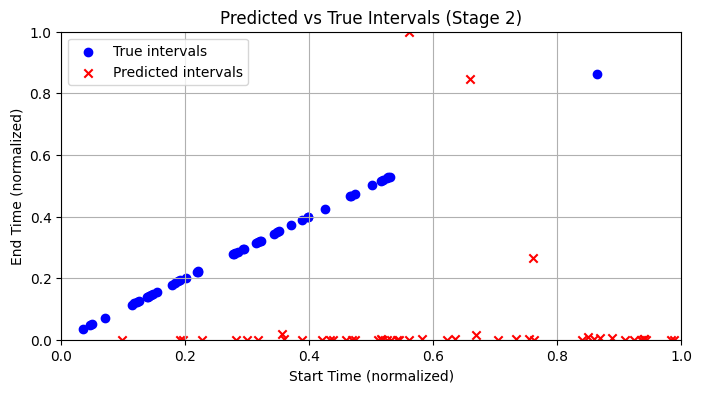

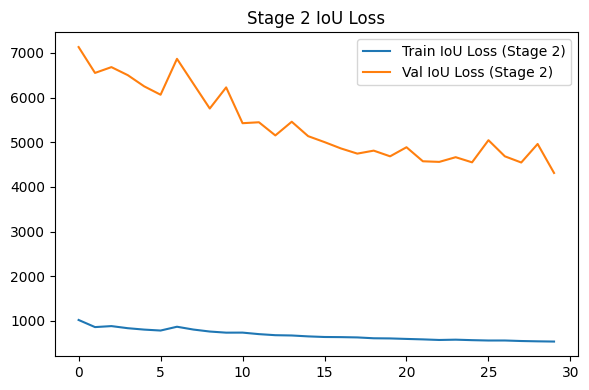

In [39]:

# Run training (replace filenames with your actual data paths)
audio_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.wav"
annotation_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.txt"

train_and_evaluate_Regression(audio_path, annotation_path, num_epochs=30, batch_size=32)

# Using Grid Search For Hyper-Parameter Tuning (stage 2 model)

In [40]:
param_grid = {
    'lr': [1e-3, 1e-4],
    'batch_size': [16, 32],
    'weight_decay': [1e-4, 1e-5],
    'dropout': [0.2, 0.3],
}


In [41]:
class Stage2Model(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.AvgPool2d(2)
        self.dropout = nn.Dropout(dropout)

        dummy = torch.zeros(1, 1, 128, 32)
        out = self._forward_conv(dummy)
        flat = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat, 128)
        self.fc_scale = nn.Linear(128, 1)
        self.fc_offset = nn.Linear(128, 1)

    def _forward_conv(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        scale = torch.sigmoid(self.fc_scale(x))
        offset = torch.sigmoid(self.fc_offset(x))
        return scale, offset


In [42]:
from itertools import product

def run_grid_search(audio_file, annotation_file, param_grid, num_epochs=5):
    best_val_loss = float('inf')
    best_params = None

    keys, values = zip(*param_grid.items())
    for param_values in product(*values):
        params = dict(zip(keys, param_values))
        print(f"\n Trying combination: {params}")

        train_loader, val_loader, _ = prepare_dataloaders(audio_file, annotation_file, batch_size=params['batch_size'])

        model = Stage2Model(dropout=params['dropout']).to(device)
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        val_losses = []

        for epoch in range(num_epochs):
            model.train()
            for X, y, s, e in train_loader:
                X, y, s, e = X.to(device), y.to(device), s.to(device), e.to(device)
                mask = (y != BowelSoundDataset.LABEL_MAP['none'])
                if mask.sum() == 0:
                    continue

                Xp, sp, ep = X[mask], s[mask], e[mask]
                optimizer.zero_grad()
                scale_p, offset_p = model(Xp)
                loss = sum(modified_iou_loss(scale_p[i], offset_p[i], sp[i], ep[i]) for i in range(Xp.size(0)))
                loss = loss / Xp.size(0)
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            total_val_loss = 0.0
            with torch.no_grad():
                for X, y, s, e in val_loader:
                    X, y, s, e = X.to(device), y.to(device), s.to(device), e.to(device)
                    mask = (y != BowelSoundDataset.LABEL_MAP['none'])
                    if mask.sum() == 0:
                        continue

                    Xp, sp, ep = X[mask], s[mask], e[mask]
                    scale_p, offset_p = model(Xp)
                    loss = sum(modified_iou_loss(scale_p[i], offset_p[i], sp[i], ep[i]) for i in range(Xp.size(0)))
                    total_val_loss += loss.item()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {avg_val_loss:.4f}")

        final_loss = val_losses[-1]
        if final_loss < best_val_loss:
            best_val_loss = final_loss
            best_params = params
            print(" New best combination!")

    print(f"\n Best parameters: {best_params}, Final Val Loss: {best_val_loss:.4f}")
    return best_params

    audio_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.wav"
annotation_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.txt"

best = run_grid_search(audio_path, annotation_path, param_grid, num_epochs=5)



🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 0.0001, 'dropout': 0.2}
Epoch 1/5, Val Loss: 7957.6965
Epoch 2/5, Val Loss: 7957.6965
Epoch 3/5, Val Loss: 7957.6965
Epoch 4/5, Val Loss: 7957.6965
Epoch 5/5, Val Loss: 7957.6965
✅ New best combination!

🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 0.0001, 'dropout': 0.3}
Epoch 1/5, Val Loss: 8214.4811
Epoch 2/5, Val Loss: 8214.4811
Epoch 3/5, Val Loss: 8214.4811
Epoch 4/5, Val Loss: 8214.4811
Epoch 5/5, Val Loss: 8214.4811

🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-05, 'dropout': 0.2}
Epoch 1/5, Val Loss: 7932.2832
Epoch 2/5, Val Loss: 7932.2832
Epoch 3/5, Val Loss: 7932.2832
Epoch 4/5, Val Loss: 7932.2832
Epoch 5/5, Val Loss: 7932.2832
✅ New best combination!

🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-05, 'dropout': 0.3}


KeyboardInterrupt: 

# Using Grid Search For Hyper-Parameter Tuning (stage 1 model)

In [43]:
class Stage1Model(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool1 = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.AvgPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool3 = nn.AvgPool2d(2)
        self.dropout = nn.Dropout(dropout)

        dummy = torch.zeros(1, 1, 128, 32)
        out = self._forward_conv(dummy)
        flat = out.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flat, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _forward_conv(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)


In [44]:
from itertools import product
from sklearn.metrics import accuracy_score

def run_stage1_grid_search(audio_file, annotation_file, param_grid, num_epochs=5):
    best_val_acc = 0.0
    best_params = None

    keys, values = zip(*param_grid.items())
    for param_values in product(*values):
        params = dict(zip(keys, param_values))
        print(f"\n Trying combination: {params}")

        train_loader, val_loader, val_ds = prepare_dataloaders(audio_file, annotation_file, batch_size=params['batch_size'])

        model = Stage1Model(num_classes=4, dropout=params['dropout']).to(device)

        weights = torch.tensor([1/857, 1/773, 1/80, 1/3000], device=device)
        weights = weights / weights.sum()
        criterion = nn.CrossEntropyLoss(weight=weights)

        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        for epoch in range(num_epochs):
            model.train()
            for X, y, _, _ in train_loader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(X)
                loss = criterion(logits, y)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X, y, _, _ in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                pred = torch.argmax(logits, dim=1)
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(y.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        print(f"Val Accuracy: {acc:.4f}")

        if acc > best_val_acc:
            best_val_acc = acc
            best_params = params
            print(" New best combination!")

    print(f"\n Best Stage 1 parameters: {best_params}, Final Val Acc: {best_val_acc:.4f}")
    return best_params


In [45]:
param_grid_stage1 = {
    'lr': [1e-3, 1e-4],
    'batch_size': [16, 32],
    'weight_decay': [1e-4, 1e-5],
    'dropout': [0.2, 0.3]
}

audio_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.wav"
annotation_path = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.txt"

best_params_stage1 = run_stage1_grid_search(audio_path, annotation_path, param_grid_stage1, num_epochs=5)



🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 0.0001, 'dropout': 0.2}
Val Accuracy: 0.8030
 New best combination!

🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 0.0001, 'dropout': 0.3}
Val Accuracy: 0.7947

🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-05, 'dropout': 0.2}
Val Accuracy: 0.7974

🔍 Trying combination: {'lr': 0.001, 'batch_size': 16, 'weight_decay': 1e-05, 'dropout': 0.3}
Val Accuracy: 0.8062
 New best combination!

🔍 Trying combination: {'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.0001, 'dropout': 0.2}
Val Accuracy: 0.7910

🔍 Trying combination: {'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.0001, 'dropout': 0.3}
Val Accuracy: 0.8052

🔍 Trying combination: {'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-05, 'dropout': 0.2}
Val Accuracy: 0.7952

🔍 Trying combination: {'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-05, 'dropout': 0.3}
Val Accuracy: 0.8031

🔍 Trying combination: {'lr': 

## Inference on Unseen Audio – Bowel Sound Detection and Aggregation

In [25]:
# --------------------------
# Detection + Aggregation
# --------------------------
import torch
from torch.utils.data import DataLoader
import librosa
import numpy as np
from scipy.signal import butter, lfilter
from tqdm import tqdm

# Lowpass filter function
def lowpass_filter(signal, sr, cutoff=2000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, signal)

# Dataset for detection with overlapping segments
class BowelSoundDataset(torch.utils.data.Dataset):
    LABEL_MAP = {'none': 3}  # for detection, no labels used

    def __init__(self, audio_file, segment_duration=0.2, stride_duration=0.05):
        self.segment_duration = segment_duration
        self.stride_duration = stride_duration
        audio, self.sr = librosa.load(audio_file, sr=None)
        audio = lowpass_filter(audio, self.sr)
        self.segments = []
        self.start_times = []

        segment_samples = int(self.sr * segment_duration)
        stride_samples = int(self.sr * stride_duration)

        for i in range(0, len(audio) - segment_samples + 1, stride_samples):
            segment = audio[i:i + segment_samples]
            spec = librosa.feature.melspectrogram(y=segment, sr=self.sr, n_fft=512, hop_length=128)
            spec_db = librosa.power_to_db(spec, ref=np.max)
            spec_db = np.pad(spec_db, ((0, 0), (0, max(0, 32 - spec_db.shape[1]))), mode='constant')[:, :32]
            self.segments.append(torch.tensor(spec_db, dtype=torch.float32).unsqueeze(0))
            self.start_times.append(i / self.sr)

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        return self.segments[idx], self.start_times[idx]

# Aggregation helper functions
def aggregate_group(group, vote_threshold):
    total_conf = sum(g["confidence"] for g in group)
    if total_conf < vote_threshold:
        return None
    return {
        "start_time": round(min(g["start_time"] for g in group), 2),
        "end_time": round(max(g["end_time"] for g in group), 2),
        "type": group[0]["type"],
        "confidence": round(total_conf, 2)
    }

def merge_detections(detections, vote_threshold=1.5, merge_gap=0.1):
    if not detections:
        return []
    detections.sort(key=lambda x: x["start_time"])
    merged, group = [], []

    for det in detections:
        if not group:
            group.append(det)
        else:
            prev = group[-1]
            if det["type"] == prev["type"] and det["start_time"] - prev["end_time"] <= merge_gap:
                group.append(det)
            else:
                merged_det = aggregate_group(group, vote_threshold)
                if merged_det:
                    merged.append(merged_det)
                group = [det]

    if group:
        merged_det = aggregate_group(group, vote_threshold)
        if merged_det:
            merged.append(merged_det)

    return merged

# Main detection function
def detect_bowel_sounds(audio_file, stage1_model, stage2_model,
                        threshold=0.9, vote_threshold=1.5, merge_gap=0.1,
                        segment_duration=0.2, stride_duration=0.05):

    dataset = BowelSoundDataset(audio_file, segment_duration, stride_duration)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)

    stage1_model.eval()
    stage2_model.eval()
    device = next(stage1_model.parameters()).device
    id_to_class = {0: "b", 1: "mb", 2: "h", 3: "none"}

    raw_detections = []
    with torch.no_grad():
        for X, segment_start in tqdm(loader, desc="Detecting"):
            X = X.to(device)
            logits = stage1_model(X)
            probs = torch.softmax(logits, dim=1)
            confidence, pred_class = torch.max(probs, dim=1)

            if pred_class.item() == 3 or confidence.item() < threshold:
                continue  # skip "none" or low-confidence

            scale, offset = stage2_model(X)
            predicted_start = segment_start.item() + offset.item()
            predicted_end = predicted_start + scale.item()

            # fallback for invalid intervals
            if predicted_end <= predicted_start:
                predicted_end = predicted_start + segment_duration

            raw_detections.append({
                "start_time": round(predicted_start, 2),
                "end_time": round(predicted_end, 2),
                "type": id_to_class[pred_class.item()],
                "confidence": round(confidence.item(), 2)
            })

    final_detections = merge_detections(raw_detections,
                                        vote_threshold=vote_threshold,
                                        merge_gap=merge_gap)
    return final_detections


# --------------------------
# Usage
# --------------------------
audio_file = "/content/drive/MyDrive/Colab Notebooks/Bowel Sound Model/AS_1.wav"

# Instantiate the models
stage1_model = Stage1Model(num_classes=4).to(device)
stage2_model = Stage2Model().to(device)

stage1_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/stage1_model.pth"))
stage2_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/stage2_model.pth"))

detections = detect_bowel_sounds(audio_file, stage1_model, stage2_model,
                                 threshold=0.9, vote_threshold=1.5, merge_gap=0.1)

for det in detections:
    print(f"Start Time: {det['start_time']}s, End Time: {det['end_time']}s, Type: {det['type']}, Confidence: {det['confidence']}")


Detecting: 100%|██████████| 44245/44245 [00:33<00:00, 1311.90it/s]


Start Time: 1.03s, End Time: 1.93s, Type: h, Confidence: 3.9
Start Time: 13.2s, End Time: 13.83s, Type: mb, Confidence: 1.89
Start Time: 46.2s, End Time: 46.65s, Type: mb, Confidence: 3.85
Start Time: 47.39s, End Time: 48.61s, Type: mb, Confidence: 7.77
Start Time: 49.48s, End Time: 50.28s, Type: mb, Confidence: 3.87
Start Time: 50.86s, End Time: 52.98s, Type: h, Confidence: 35.8
Start Time: 58.75s, End Time: 59.48s, Type: h, Confidence: 8.91
Start Time: 60.4s, End Time: 60.56s, Type: mb, Confidence: 1.96
Start Time: 66.4s, End Time: 66.72s, Type: mb, Confidence: 1.9
Start Time: 67.6s, End Time: 67.8s, Type: b, Confidence: 1.99
Start Time: 69.5s, End Time: 69.69s, Type: mb, Confidence: 2.82
Start Time: 71.05s, End Time: 71.79s, Type: mb, Confidence: 2.89
Start Time: 72.7s, End Time: 73.52s, Type: h, Confidence: 7.83
Start Time: 77.3s, End Time: 77.52s, Type: b, Confidence: 1.97
Start Time: 78.25s, End Time: 78.77s, Type: mb, Confidence: 3.84
Start Time: 84.54s, End Time: 85.16s, Type: 